### Linear Regression on Human Observed Dataset with concatenation

In [15]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03 #for regularization of closed form
TrainingPercent = 70
ValidationPercent = 15
TestPercent = 15
M = 18 # no of basis function
PHI = [] #Matrix for basis function
IsSynthetic = False

def GetTargetVector(filePath,k):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[k]))
    #print("Raw Training Generated..")
    return t
#append the csv file data in dataMatrix
def GenerateRawData(filePath, IsSynthetic,k):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row[0:k]:

                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    dataMatrix = np.transpose(dataMatrix)
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t
#Big sigma contains variance at the diagonal elements
#Big sigma contains variance at the diagonal elements
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    print(len(Data)) #rows 41#
    print(len(Data[0])) #columns 69k
    print(Data.shape)
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    print(len(DataT[0]))#column
    print(DataT.shape)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):#all columns of one feature
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))# variance of each feature vector as diagonal
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):#computing exponent function of gaussian basis function
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    # compute phi matrix
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI
#Computation of closed form solution to obtain weights
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W


#For obtaining validation erms , testing erms and training erms
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y
#get erms by subtracting actual value - obtained value and then squaring it 
#and then summing all of them.
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))




In [16]:
RawTarget = GetTargetVector('final1600.csv',18)
RawData   = GenerateRawData('final1600.csv',IsSynthetic,18)

TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)


ErmsArr = []
AccuracyArr = []
#In order to get different Mu specify value of M in K- Means
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 

TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 'U' mode is deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 'U' mode is deprecated


(1109,)
(18, 1109)
(237,)
(18, 237)
(237,)
(18, 237)
18
1583
(18, 1583)
18
(1583, 18)


In [17]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt


W_Now        = np.zeros(18) #Randomly intiliaze weight at the beguning

La           = 2
learningRate = 0.01 #determines the step size for updating weights
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,1000):
    #process of updation of wts acc to stochastic gradient descent solution
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [18]:
print('UBIT: abiseria')
print('personNo:50291145')
print ('----------Gradient Descent Solution--------------------')
print ("M = 18 \nLambda  = 0.0001\neta=0.003")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))



UBIT: abiseria
personNo:50291145
----------Gradient Descent Solution--------------------
M = 18 
Lambda  = 0.0001
eta=0.003
E_rms Training   = 0.49943
E_rms Validation = 0.49939
E_rms Testing    = 0.49968


### Logistic Regression with Human Observed Dataset with concatenation

In [21]:
TrainingData = np.transpose(TrainingData)
wnew = np.zeros(18)
b =0 
for i in range(1100):
    #wnew = np.transpose(wnew)
    z = np.dot(np.transpose(wnew),TrainingData[i]) + b
    a = 1.0/(1.0+ math.exp(-z))
    #wnext = wnew - eta*(a-y)*xi
    wnext = wnew - np.dot(learningRate*(a-TrainingTarget[i]),TrainingData[i])
    wnew = wnext
    
    b = b - learningRate*(a - TrainingTarget[i])

In [26]:
test = []
def GetValTestLog(VAL_PHI,W):
    for i in range(1100):
        
        Y = np.dot(W,VAL_PHI[i])
        a = 1.0/(1.0+ math.exp(-Y))
        test.append(a) 
    return test
TR_TEST_OUT   = GetValTestLog(TrainingData,wnew) 

Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
L_Erms_Val.append(float(Erms_Val.split(',')[0]))
#print ("Accuracy Training   = " + str(np.around(min(L_Erms_TR),5)))
print("Accuracy Training = " + str(float(Erms_TR.split(',')[0])))

test = []
ValData = np.transpose(ValData)
def GetValTestLog(VAL_PHI,W):
    for i in range(237):
        
        Y = np.dot(W,VAL_PHI[i])
        a = 1.0/(1.0+ math.exp(-Y))
        test.append(a) 
    return test
TR_TEST_OUT   = GetValTestLog(ValData,wnew) 

Erms_TR       = GetErms(TR_TEST_OUT,ValDataAct)
L_Erms_Val.append(float(Erms_Val.split(',')[0]))
#print ("Accuracy Validation = " + str(np.around(min(L_Erms_Val),5)))
print("Accuracy Validation = " + str(float(Erms_TR.split(',')[0])))

test1 = []
TestData = np.transpose(TestData)
def GetTestLog(VAL_PHI,W):
    for i in range(236):
        
        Y = np.dot(W,VAL_PHI[i])
        a = 1.0/(1.0+ math.exp(-Y))
        test1.append(a) 
    return test1
TR_TEST_OUT   = GetTestLog(TestData,wnew) 

Erms_TR       = GetErms(TR_TEST_OUT,TestDataAct)
L_Erms_Test.append(float(Erms_Test.split(',')[0]))
#print ("accuracy Testing    = " + str(np.around(min(L_Erms_Test),5)))
print("Accuracy Testing = " + str(float(Erms_TR.split(',')[0])))

Accuracy Training = 54.36363636363637
Accuracy Validation = 48.52320675105485
Accuracy Testing = 48.728813559322035


### Linear Regression on Human Observed Dataset using subtraction

In [138]:
M = 9
RawTarget = GetTargetVector('final_sub.csv',9)
RawData   = GenerateRawData('final_sub.csv',IsSynthetic,9)

TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)


ErmsArr = []
AccuracyArr = []
#In order to get different Mu specify value of M in K- Means
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 

TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 'U' mode is deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 'U' mode is deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


(1265,)
(9, 1265)
(158,)
(9, 158)
(158,)
(9, 158)
9
1581
(9, 1581)
9
(1581, 9)


In [139]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt


W_Now        = np.zeros(9) #Randomly intiliaze weight at the beguning
print(W_Now)
La           = 2
learningRate = 0.01 #determines the step size for updating weights
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,1000):
    #process of updation of wts acc to stochastic gradient descent solution
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [140]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 9 \nLambda  = 0.0001\neta=0.003")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))



----------Gradient Descent Solution--------------------
M = 9 
Lambda  = 0.0001
eta=0.003
E_rms Training   = 0.50008
E_rms Validation = 0.49995
E_rms Testing    = 0.49511


### Logistic Regression on Human Observed Dataset with subtraction


In [141]:
TrainingData = np.transpose(TrainingData)
wnew = np.zeros(9)
b =0 
for i in range(1100):
    #wnew = np.transpose(wnew)
    z = np.dot(np.transpose(wnew),TrainingData[i]) + b
    a = 1.0/(1.0+ math.exp(-z))
    #wnext = wnew - eta*(a-y)*xi
    wnext = wnew - np.dot(learningRate*(a-TrainingTarget[i]),TrainingData[i])
    wnew = wnext
    
    b = b - learningRate*(a - TrainingTarget[i])

In [152]:
test = []
def GetValTestLog(VAL_PHI,W):
    for i in range(1100):
        
        Y = np.dot(W,VAL_PHI[i])
        a = 1.0/(1.0+ math.exp(-Y))
        test.append(a) 
    return test
TR_TEST_OUT   = GetValTestLog(TrainingData,wnew) 

Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
L_Erms_Val.append(float(Erms_Val.split(',')[0]))
#print ("Accuracy Training   = " + str(np.around(min(L_Erms_TR),5)))
print("Accuracy Training = " + str(float(Erms_TR.split(',')[0])))


test = []
ValData = np.transpose(ValData)
def GetValTestLog(VAL_PHI,W):
    for i in range(100):
        
        Y = np.dot(W,VAL_PHI[i])
        a = 1.0/(1.0+ math.exp(-Y))
        test.append(a) 
    return test
TR_TEST_OUT   = GetValTestLog(ValData,wnew) 

Erms_TR       = GetErms(TR_TEST_OUT,ValDataAct)
L_Erms_Val.append(float(Erms_Val.split(',')[0]))
#print ("Accuracy Validation = " + str(np.around(min(L_Erms_Val),5)))
print("Accuracy Validation = " + str(float(Erms_TR.split(',')[0])))

test1 = []
TestData = np.transpose(TestData)
def GetTestLog(VAL_PHI,W):
    for i in range(100):
        
        Y = np.dot(W,VAL_PHI[i])
        a = 1.0/(1.0+ math.exp(-Y))
        test1.append(a) 
    return test1
TR_TEST_OUT   = GetTestLog(TestData,wnew) 

Erms_TR       = GetErms(TR_TEST_OUT,TestDataAct)
L_Erms_Test.append(float(Erms_Test.split(',')[0]))
#print ("accuracy Testing    = " + str(np.around(min(L_Erms_Test),5)))
print("Accuracy Testing = " + str(float(Erms_TR.split(',')[0])))



Accuracy Training = 49.18181818181818
Accuracy Validation = 49.0
Accuracy Testing = 49.0


### Keras implementation on Human Observed Dataset with concatenation

In [49]:
import pandas as pd
def processData(dataset):
    
    # Why do we have to process?  We do not needvindexes, we only need values.
    #We are converting the dataset back to array 
    #for further processing them to binary form
    data   = dataset.iloc[:1481,0:18]
    labels = dataset.iloc[:1481,18]
    #to separately pass arrays to two different codes we converted the dataset to two different arrays
    #processedData  = encodeData(data)
    #processedLabel = encodeLabel(labels)
    print (data)
    print(labels)
    return data, labels

def testData(dataset):
    data   = dataset.iloc[1482:,0:18]
    labels = dataset.iloc[1482:,18]
    #to separately pass arrays to two different codes we converted the dataset to two different arrays
    #processedData  = encodeData(data)
    #processedLabel = encodeLabel(labels)
    #print (data)
    #print(labels)
    return data, labels

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import SGD
import numpy as np

input_size = 18
drop_out = 0.2
first_dense_layer_nodes  = 512
second_dense_layer = 512
second_dense_layer_nodes = 1

def get_model():
    
    # Why do we need a model? A model is a core data  srtucture in keras and used to organize layers.
    # Why use Dense layer and then activation? We need to tell the system how the model is by specifying input and dense layer size,
    #after specifying we apply activation.
    # Why use sequential model with layers? sequential model is a linear way of stacking layers, 
    #where a layer connects just to the next layer. Here we have a fixed souce of input and output.
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    #relu always gives value such that if x<0 it will give 0 otherwise it will give the number itself
    #activation function are used to map input to output
    
    # Why dropout? WE used dropout to avoid overfitting of model
    model.add(Dropout(drop_out))
    model.add(Dense(second_dense_layer))
    model.add(Activation('relu'))
        
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('sigmoid'))
    # Why Softmax?
    # softmax is an activation function used when we are doing classification 
    #and softmax will give probabilities of various classes involved
    model.summary()
    
    # Why use categorical_crossentropy? We use categorial cross entropy when the target is in categorical format
    # Here we are distribuiting the number in 4 categories, thus using categorical crossentropy
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # optimizer allows the internal learnable parameter (weights)to get adjusted.
    return model

Using TensorFlow backend.
/Users/apoorvabisaria/tensorflowml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [50]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               9728      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________


In [51]:
validation_data_split = 0.2
num_epochs = 1100
model_batch_size = 128
tb_batch_size = 20
early_patience = 100
#tensorboard is used for visualization
tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
#earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
#Early stopping happens when the quantity monitored stops increasing or decreasing
# Read Dataset
dataset = pd.read_csv('final1600.csv')

# Process Dataset
processedData, processedLabel = processData(dataset)
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb]
                   )



      1  1.1  0  3  2  2.1  1.2  3.1  2.2  1.3  1.4  1.5  2.3  0.1  1.6  1.7  \
0     2    1  1  0  2    2    1    2    1    3    1    1    0    2    3    1   
1     1    1  1  0  0    2    0    1    2    2    1    1    3    2    2    1   
2     3    0  1  3  2    1    0    2    2    2    4    1    3    2    1    1   
3     1    1  1  3  2    0    0    0    2    1    0    0    1    0    2    2   
4     1    2  1  0  0    2    1    0    2    1    1    1    0    0    3    3   
5     1    1  1  1  2    2    0    0    2    2    2    1    0    0    2    0   
6     0    1  1  1  2    2    0    4    2    2    1    1    2    2    2    1   
7     2    2  1  3  2    2    0    2    2    1    1    2    3    2    2    1   
8     2    1  1  0  2    1    0    0    2    2    1    1    3    0    2    1   
9     2    1  1  0  2    1    0    0    1    2    0    1    0    0    3    0   
10    2    0  1  1  2    2    1    2    1    2    0    1    1    0    2    0   
11    3    4  1  3  2    3    1    2    

Epoch 1/1100
1184/1184 [==============================] - 0s 141us/step - loss: 0.7133 - acc: 0.5177 - val_loss: 0.7077 - val_acc: 0.5152
Epoch 2/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.6974 - acc: 0.5270 - val_loss: 0.6846 - val_acc: 0.5421
Epoch 3/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.6861 - acc: 0.5633 - val_loss: 0.7051 - val_acc: 0.5152
Epoch 4/1100
1184/1184 [==============================] - 0s 21us/step - loss: 0.6871 - acc: 0.5389 - val_loss: 0.7136 - val_acc: 0.5118
Epoch 5/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.6829 - acc: 0.5431 - val_loss: 0.6915 - val_acc: 0.5387
Epoch 6/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.6730 - acc: 0.5794 - val_loss: 0.6982 - val_acc: 0.5219
Epoch 7/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.6707 - acc: 0.6149 - val_loss: 0.6829 - val_acc: 0.5455
Epoch 8/1100
1184/1184 [================

1184/1184 [==============================] - 0s 19us/step - loss: 0.5687 - acc: 0.7145 - val_loss: 0.7258 - val_acc: 0.5421
Epoch 61/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.5670 - acc: 0.7019 - val_loss: 0.7235 - val_acc: 0.5084
Epoch 62/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.5663 - acc: 0.7382 - val_loss: 0.7595 - val_acc: 0.5320
Epoch 63/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.5633 - acc: 0.7120 - val_loss: 0.7675 - val_acc: 0.5320
Epoch 64/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.5714 - acc: 0.7095 - val_loss: 0.7770 - val_acc: 0.5320
Epoch 65/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.5651 - acc: 0.7162 - val_loss: 0.7389 - val_acc: 0.5354
Epoch 66/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.5542 - acc: 0.7264 - val_loss: 0.7967 - val_acc: 0.4983
Epoch 67/1100
1184/1184 [=======================

1184/1184 [==============================] - 0s 19us/step - loss: 0.4698 - acc: 0.7863 - val_loss: 0.7846 - val_acc: 0.5152
Epoch 120/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.4728 - acc: 0.7956 - val_loss: 0.7725 - val_acc: 0.5286
Epoch 121/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.4607 - acc: 0.8024 - val_loss: 0.7741 - val_acc: 0.5051
Epoch 122/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.4772 - acc: 0.7787 - val_loss: 0.8179 - val_acc: 0.5185
Epoch 123/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.4619 - acc: 0.8074 - val_loss: 0.8207 - val_acc: 0.5185
Epoch 124/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.4668 - acc: 0.7931 - val_loss: 0.7714 - val_acc: 0.5084
Epoch 125/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.4669 - acc: 0.7990 - val_loss: 0.8046 - val_acc: 0.5051
Epoch 126/1100
1184/1184 [================

1184/1184 [==============================] - 0s 20us/step - loss: 0.3976 - acc: 0.8463 - val_loss: 0.8215 - val_acc: 0.5286
Epoch 179/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.3940 - acc: 0.8421 - val_loss: 0.8303 - val_acc: 0.5286
Epoch 180/1100
1184/1184 [==============================] - 0s 21us/step - loss: 0.3706 - acc: 0.8682 - val_loss: 0.8553 - val_acc: 0.5253
Epoch 181/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.3642 - acc: 0.8750 - val_loss: 0.8396 - val_acc: 0.5118
Epoch 182/1100
1184/1184 [==============================] - 0s 21us/step - loss: 0.3943 - acc: 0.8539 - val_loss: 0.8457 - val_acc: 0.5286
Epoch 183/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.3685 - acc: 0.8699 - val_loss: 0.8732 - val_acc: 0.5253
Epoch 184/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.3788 - acc: 0.8691 - val_loss: 0.8450 - val_acc: 0.5152
Epoch 185/1100
1184/1184 [================

1184/1184 [==============================] - 0s 19us/step - loss: 0.3040 - acc: 0.8986 - val_loss: 0.9156 - val_acc: 0.5421
Epoch 238/1100
1184/1184 [==============================] - 0s 22us/step - loss: 0.3186 - acc: 0.8834 - val_loss: 0.9204 - val_acc: 0.5286
Epoch 239/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.3129 - acc: 0.8961 - val_loss: 0.8835 - val_acc: 0.5185
Epoch 240/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.3133 - acc: 0.8978 - val_loss: 0.8908 - val_acc: 0.5286
Epoch 241/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2989 - acc: 0.9054 - val_loss: 0.9148 - val_acc: 0.5286
Epoch 242/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.3048 - acc: 0.9046 - val_loss: 0.9032 - val_acc: 0.5253
Epoch 243/1100
1184/1184 [==============================] - 0s 23us/step - loss: 0.3022 - acc: 0.9012 - val_loss: 0.9088 - val_acc: 0.5387
Epoch 244/1100
1184/1184 [================

1184/1184 [==============================] - 0s 19us/step - loss: 0.2460 - acc: 0.9400 - val_loss: 0.9639 - val_acc: 0.5488
Epoch 297/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.2831 - acc: 0.8910 - val_loss: 1.0039 - val_acc: 0.5219
Epoch 298/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.2438 - acc: 0.9375 - val_loss: 0.9594 - val_acc: 0.5354
Epoch 299/1100
1184/1184 [==============================] - 0s 21us/step - loss: 0.2531 - acc: 0.9291 - val_loss: 0.9625 - val_acc: 0.5387
Epoch 300/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2410 - acc: 0.9459 - val_loss: 1.0906 - val_acc: 0.5219
Epoch 301/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.2664 - acc: 0.9139 - val_loss: 0.9596 - val_acc: 0.5488
Epoch 302/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2378 - acc: 0.9434 - val_loss: 0.9704 - val_acc: 0.5253
Epoch 303/1100
1184/1184 [================

1184/1184 [==============================] - 0s 19us/step - loss: 0.1957 - acc: 0.9654 - val_loss: 1.0407 - val_acc: 0.5387
Epoch 356/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.2327 - acc: 0.9181 - val_loss: 1.0249 - val_acc: 0.5320
Epoch 357/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.1862 - acc: 0.9738 - val_loss: 1.0812 - val_acc: 0.5387
Epoch 358/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.1885 - acc: 0.9628 - val_loss: 1.0729 - val_acc: 0.5354
Epoch 359/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2256 - acc: 0.9307 - val_loss: 1.0255 - val_acc: 0.5556
Epoch 360/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.1902 - acc: 0.9578 - val_loss: 1.0325 - val_acc: 0.5320
Epoch 361/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.1889 - acc: 0.9620 - val_loss: 1.2509 - val_acc: 0.5152
Epoch 362/1100
1184/1184 [================

1184/1184 [==============================] - 0s 21us/step - loss: 0.1725 - acc: 0.9519 - val_loss: 1.1426 - val_acc: 0.5387
Epoch 415/1100
1184/1184 [==============================] - 0s 25us/step - loss: 0.1753 - acc: 0.9645 - val_loss: 1.1150 - val_acc: 0.5219
Epoch 416/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.1439 - acc: 0.9840 - val_loss: 1.2819 - val_acc: 0.5354
Epoch 417/1100
1184/1184 [==============================] - 0s 24us/step - loss: 0.1842 - acc: 0.9426 - val_loss: 1.2097 - val_acc: 0.5387
Epoch 418/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.1592 - acc: 0.9688 - val_loss: 1.2257 - val_acc: 0.5387
Epoch 419/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.1732 - acc: 0.9561 - val_loss: 1.1070 - val_acc: 0.5589
Epoch 420/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.1735 - acc: 0.9535 - val_loss: 1.1165 - val_acc: 0.5286
Epoch 421/1100
1184/1184 [================

1184/1184 [==============================] - 0s 17us/step - loss: 0.1440 - acc: 0.9671 - val_loss: 1.2122 - val_acc: 0.5421
Epoch 474/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.1422 - acc: 0.9654 - val_loss: 1.1943 - val_acc: 0.5455
Epoch 475/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.1246 - acc: 0.9848 - val_loss: 1.2287 - val_acc: 0.5286
Epoch 476/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.1310 - acc: 0.9789 - val_loss: 1.2635 - val_acc: 0.5387
Epoch 477/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.1457 - acc: 0.9730 - val_loss: 1.1910 - val_acc: 0.5354
Epoch 478/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.1303 - acc: 0.9780 - val_loss: 1.2732 - val_acc: 0.5455
Epoch 479/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.1318 - acc: 0.9755 - val_loss: 1.2284 - val_acc: 0.5455
Epoch 480/1100
1184/1184 [================

1184/1184 [==============================] - 0s 20us/step - loss: 0.1137 - acc: 0.9797 - val_loss: 1.4037 - val_acc: 0.5522
Epoch 533/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.0972 - acc: 0.9899 - val_loss: 1.2806 - val_acc: 0.5455
Epoch 534/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.1147 - acc: 0.9831 - val_loss: 1.3006 - val_acc: 0.5320
Epoch 535/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.1028 - acc: 0.9865 - val_loss: 1.2939 - val_acc: 0.5320
Epoch 536/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.0939 - acc: 0.9941 - val_loss: 1.2858 - val_acc: 0.5488
Epoch 537/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.1236 - acc: 0.9704 - val_loss: 1.3168 - val_acc: 0.5589
Epoch 538/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.0963 - acc: 0.9924 - val_loss: 1.2861 - val_acc: 0.5455
Epoch 539/1100
1184/1184 [================

1184/1184 [==============================] - 0s 16us/step - loss: 0.0828 - acc: 0.9899 - val_loss: 1.3969 - val_acc: 0.5354
Epoch 592/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.0756 - acc: 0.9949 - val_loss: 1.6087 - val_acc: 0.5354
Epoch 593/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.1053 - acc: 0.9780 - val_loss: 1.3565 - val_acc: 0.5589
Epoch 594/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.0796 - acc: 0.9958 - val_loss: 1.3927 - val_acc: 0.5623
Epoch 595/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.0914 - acc: 0.9882 - val_loss: 1.3966 - val_acc: 0.5354
Epoch 596/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.0808 - acc: 0.9907 - val_loss: 1.4027 - val_acc: 0.5387
Epoch 597/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0789 - acc: 0.9949 - val_loss: 1.3946 - val_acc: 0.5286
Epoch 598/1100
1184/1184 [================

1184/1184 [==============================] - 0s 22us/step - loss: 0.0807 - acc: 0.9831 - val_loss: 1.5234 - val_acc: 0.5253
Epoch 651/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.0553 - acc: 1.0000 - val_loss: 1.4599 - val_acc: 0.5152
Epoch 652/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.0730 - acc: 0.9890 - val_loss: 1.5934 - val_acc: 0.5286
Epoch 653/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.0626 - acc: 0.9958 - val_loss: 1.4791 - val_acc: 0.5354
Epoch 654/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.0549 - acc: 0.9983 - val_loss: 1.6403 - val_acc: 0.5387
Epoch 655/1100
1184/1184 [==============================] - 0s 23us/step - loss: 0.0815 - acc: 0.9882 - val_loss: 1.5347 - val_acc: 0.5320
Epoch 656/1100
1184/1184 [==============================] - 0s 21us/step - loss: 0.0599 - acc: 0.9975 - val_loss: 1.5207 - val_acc: 0.5387
Epoch 657/1100
1184/1184 [================

1184/1184 [==============================] - 0s 15us/step - loss: 0.0580 - acc: 0.9949 - val_loss: 1.5530 - val_acc: 0.5421
Epoch 710/1100
1184/1184 [==============================] - 0s 14us/step - loss: 0.0468 - acc: 0.9992 - val_loss: 1.5911 - val_acc: 0.5354
Epoch 711/1100
1184/1184 [==============================] - 0s 14us/step - loss: 0.0659 - acc: 0.9924 - val_loss: 1.5449 - val_acc: 0.5253
Epoch 712/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0481 - acc: 0.9983 - val_loss: 1.7355 - val_acc: 0.5387
Epoch 713/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0507 - acc: 0.9958 - val_loss: 1.5700 - val_acc: 0.5219
Epoch 714/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0671 - acc: 0.9865 - val_loss: 1.6710 - val_acc: 0.5488
Epoch 715/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0461 - acc: 0.9983 - val_loss: 1.5486 - val_acc: 0.5286
Epoch 716/1100
1184/1184 [================

1184/1184 [==============================] - 0s 14us/step - loss: 0.0339 - acc: 0.9992 - val_loss: 1.6349 - val_acc: 0.5354
Epoch 769/1100
1184/1184 [==============================] - 0s 14us/step - loss: 0.0303 - acc: 1.0000 - val_loss: 1.6603 - val_acc: 0.5286
Epoch 770/1100
1184/1184 [==============================] - 0s 13us/step - loss: 0.0769 - acc: 0.9840 - val_loss: 1.6287 - val_acc: 0.5455
Epoch 771/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0307 - acc: 1.0000 - val_loss: 1.6395 - val_acc: 0.5320
Epoch 772/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.0438 - acc: 0.9958 - val_loss: 1.8259 - val_acc: 0.5455
Epoch 773/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.0372 - acc: 0.9983 - val_loss: 1.6681 - val_acc: 0.5219
Epoch 774/1100
1184/1184 [==============================] - 0s 14us/step - loss: 0.0394 - acc: 0.9992 - val_loss: 1.7701 - val_acc: 0.5320
Epoch 775/1100
1184/1184 [================

1184/1184 [==============================] - 0s 15us/step - loss: 0.0237 - acc: 1.0000 - val_loss: 1.7607 - val_acc: 0.5320
Epoch 828/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.0369 - acc: 0.9992 - val_loss: 1.8007 - val_acc: 0.5253
Epoch 829/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.0324 - acc: 0.9983 - val_loss: 1.7426 - val_acc: 0.5185
Epoch 830/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.0247 - acc: 1.0000 - val_loss: 2.0312 - val_acc: 0.5354
Epoch 831/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.0632 - acc: 0.9780 - val_loss: 1.7291 - val_acc: 0.5320
Epoch 832/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.0226 - acc: 1.0000 - val_loss: 1.7346 - val_acc: 0.5421
Epoch 833/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.0237 - acc: 1.0000 - val_loss: 1.7413 - val_acc: 0.5253
Epoch 834/1100
1184/1184 [================

1184/1184 [==============================] - 0s 19us/step - loss: 0.0177 - acc: 1.0000 - val_loss: 1.7979 - val_acc: 0.5286
Epoch 887/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.0178 - acc: 1.0000 - val_loss: 1.8028 - val_acc: 0.5320
Epoch 888/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.0423 - acc: 0.9916 - val_loss: 1.8804 - val_acc: 0.5286
Epoch 889/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.0197 - acc: 1.0000 - val_loss: 1.8438 - val_acc: 0.5421
Epoch 890/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0185 - acc: 1.0000 - val_loss: 1.8205 - val_acc: 0.5354
Epoch 891/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.0285 - acc: 0.9983 - val_loss: 1.8160 - val_acc: 0.5455
Epoch 892/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.0197 - acc: 1.0000 - val_loss: 1.8500 - val_acc: 0.5488
Epoch 893/1100
1184/1184 [================

1184/1184 [==============================] - 0s 14us/step - loss: 0.0425 - acc: 0.9966 - val_loss: 1.8582 - val_acc: 0.5488
Epoch 946/1100
1184/1184 [==============================] - 0s 13us/step - loss: 0.0137 - acc: 1.0000 - val_loss: 1.8827 - val_acc: 0.5387
Epoch 947/1100
1184/1184 [==============================] - 0s 13us/step - loss: 0.0145 - acc: 1.0000 - val_loss: 1.8510 - val_acc: 0.5387
Epoch 948/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0383 - acc: 0.9932 - val_loss: 1.9138 - val_acc: 0.5320
Epoch 949/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0150 - acc: 1.0000 - val_loss: 1.8848 - val_acc: 0.5354
Epoch 950/1100
1184/1184 [==============================] - 0s 13us/step - loss: 0.0140 - acc: 1.0000 - val_loss: 1.9722 - val_acc: 0.5253
Epoch 951/1100
1184/1184 [==============================] - 0s 14us/step - loss: 0.0304 - acc: 0.9992 - val_loss: 1.8590 - val_acc: 0.5286
Epoch 952/1100
1184/1184 [================

1184/1184 [==============================] - 0s 14us/step - loss: 0.0112 - acc: 1.0000 - val_loss: 1.9757 - val_acc: 0.5320
Epoch 1005/1100
1184/1184 [==============================] - 0s 14us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 1.9569 - val_acc: 0.5253
Epoch 1006/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 2.0042 - val_acc: 0.5421
Epoch 1007/1100
1184/1184 [==============================] - 0s 13us/step - loss: 0.0525 - acc: 0.9789 - val_loss: 1.9601 - val_acc: 0.5488
Epoch 1008/1100
1184/1184 [==============================] - 0s 14us/step - loss: 0.0105 - acc: 1.0000 - val_loss: 1.9541 - val_acc: 0.5387
Epoch 1009/1100
1184/1184 [==============================] - 0s 14us/step - loss: 0.0103 - acc: 1.0000 - val_loss: 1.9704 - val_acc: 0.5421
Epoch 1010/1100
1184/1184 [==============================] - 0s 13us/step - loss: 0.0103 - acc: 1.0000 - val_loss: 1.9710 - val_acc: 0.5421
Epoch 1011/1100
1184/1184 [=========

1184/1184 [==============================] - 0s 14us/step - loss: 0.0083 - acc: 1.0000 - val_loss: 2.0429 - val_acc: 0.5320
Epoch 1063/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 2.0820 - val_acc: 0.5253
Epoch 1064/1100
1184/1184 [==============================] - 0s 14us/step - loss: 0.0197 - acc: 1.0000 - val_loss: 2.0325 - val_acc: 0.5488
Epoch 1065/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 2.0335 - val_acc: 0.5354
Epoch 1066/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0168 - acc: 0.9983 - val_loss: 2.4896 - val_acc: 0.5286
Epoch 1067/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.0251 - acc: 0.9941 - val_loss: 2.0415 - val_acc: 0.5253
Epoch 1068/1100
1184/1184 [==============================] - 0s 14us/step - loss: 0.0083 - acc: 1.0000 - val_loss: 2.0429 - val_acc: 0.5286
Epoch 1069/1100
1184/1184 [=========

In [53]:
datatest = pd.read_csv('final1600.csv')
datatest1,datalabel = testData(datatest)
#np.set_printoptions(precision=4, suppress=True)
k,l = datatest1.shape

eval_results = model.predict(datatest1)
#print("\nLoss, accuracy on test data: ")
#print("%0.4f %0.2f%%" % (eval_results[0], \
 #eval_results[1]*100))

for i in range(100):
    if(eval_results[i]>0.5):
        eval_results[i] = 1
    else:
        eval_results[i] = 0
        


In [54]:
correct = 0
wrong = 0
for i in range(k):
    if (eval_results[i] == datalabel[1482+i]):
        correct = correct +1
    else:
        wrong = wrong + 1
        
print (correct)

48


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c36eb52b0>,
      dtype=object)

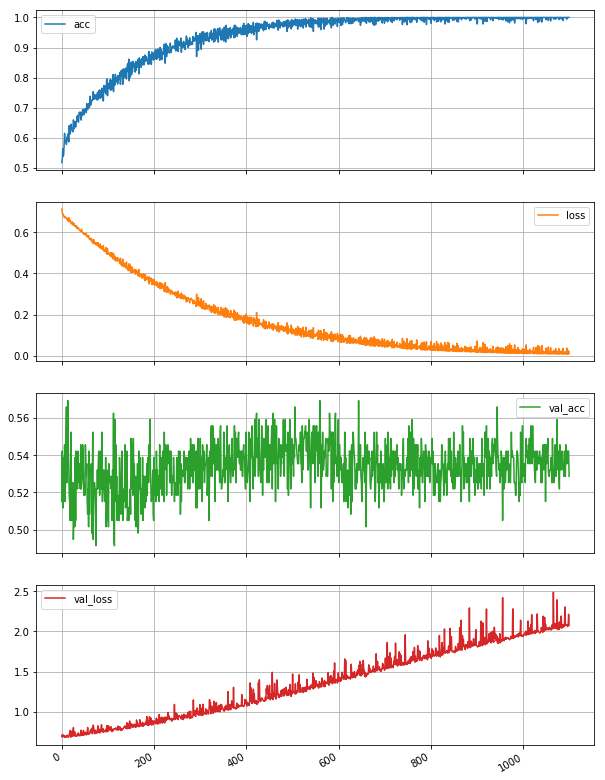

In [55]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

### Keras Implementation with Human Observed Dataset on subtraction

In [128]:
import pandas as pd

In [129]:
def processData(dataset):
    
    # Why do we have to process?  We do not needvindexes, we only need values.
    #We are converting the dataset back to array 
    #for further processing them to binary form
    data   = dataset.iloc[:1481,0:9]
    labels = dataset.iloc[:1481,9]
    #to separately pass arrays to two different codes we converted the dataset to two different arrays
    #processedData  = encodeData(data)
    #processedLabel = encodeLabel(labels)
    print (data)
    print(labels)
    return data, labels

In [130]:
def testData(dataset):
    data   = dataset.iloc[1482:,0:9]
    labels = dataset.iloc[1482:,9]
    #to separately pass arrays to two different codes we converted the dataset to two different arrays
    #processedData  = encodeData(data)
    #processedLabel = encodeLabel(labels)
    #print (data)
    #print(labels)
    return data, labels

In [131]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import SGD
import numpy as np

input_size = 9
drop_out = 0.1
first_dense_layer_nodes  = 512
second_dense_layer = 512
second_dense_layer_nodes = 1

def get_model():
    
    # Why do we need a model? A model is a core data  srtucture in keras and used to organize layers.
    # Why use Dense layer and then activation? We need to tell the system how the model is by specifying input and dense layer size,
    #after specifying we apply activation.
    # Why use sequential model with layers? sequential model is a linear way of stacking layers, 
    #where a layer connects just to the next layer. Here we have a fixed souce of input and output.
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    #relu always gives value such that if x<0 it will give 0 otherwise it will give the number itself
    #activation function are used to map input to output
    
    # Why dropout? WE used dropout to avoid overfitting of model
    #model.add(Dropout(drop_out))
    #model.add(Dense(second_dense_layer))
    #model.add(Activation('relu'))
        
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('sigmoid'))
    # Why Softmax?
    # softmax is an activation function used when we are doing classification 
    #and softmax will give probabilities of various classes involved
    model.summary()
    
    # Why use categorical_crossentropy? We use categorial cross entropy when the target is in categorical format
    # Here we are distribuiting the number in 4 categories, thus using categorical crossentropy
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # optimizer allows the internal learnable parameter (weights)to get adjusted.
    return model

In [132]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               5120      
_________________________________________________________________
activation_9 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 513       
_________________________________________________________________
activation_10 (Activation)   (None, 1)                 0         
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


In [133]:
validation_data_split = 0.2
num_epochs = 1100
model_batch_size = 128
tb_batch_size = 20
early_patience = 100
#tensorboard is used for visualization
tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
#earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
#Early stopping happens when the quantity monitored stops increasing or decreasing
# Read Dataset
dataset = pd.read_csv('final_sub.csv')

# Process Dataset
processedData, processedLabel = processData(dataset)
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb]
                   )




      0  3  0.1  0.2  0.3  0.4  1  2  0.5
0     1  0    1    1    0    1  1  0    0
1     0  1    0    2    1    2  2  3    0
2     0  2    1    3    3    1  2  3    1
3     0  2    0    3    0    0  1  0    1
4     1  0    0    1    2    0  1  2    0
5     1  1    1    3    1    1  1  1    1
6     1  0    1    0    0    0  2  1    0
7     0  2    0    0    2    0  2  0    0
8     2  1    1    2    0    0  1  0    0
9     1  2    0    2    0    0  0  2    0
10    1  4    0    2    0    0  0  4    0
11    1  3    0    1    0    2  3  1    0
12    0  0    0    0    0    1  1  2    1
13    2  1    0    1    0    1  2  4    0
14    1  3    1    3    0    2  0  3    1
15    1  0    1    0    1    0  2  2    0
16    0  2    0    2    0    1  0  2    0
17    2  3    0    1    2    2  1  2    1
18    0  0    1    0    0    1  1  2    0
19    2  1    0    2    2    2  0  0    0
20    0  2    0    3    0    1  1  0    0
21    1  3    0    0    0    0  0  1    1
22    1  0    2    1    0    1  1 

1184/1184 [==============================] - 0s 21us/step - loss: 0.6545 - acc: 0.6132 - val_loss: 0.6906 - val_acc: 0.5623
Epoch 37/1100
1184/1184 [==============================] - 0s 22us/step - loss: 0.6517 - acc: 0.6275 - val_loss: 0.6847 - val_acc: 0.5825
Epoch 38/1100
1184/1184 [==============================] - 0s 26us/step - loss: 0.6515 - acc: 0.6470 - val_loss: 0.6875 - val_acc: 0.5859
Epoch 39/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.6518 - acc: 0.6385 - val_loss: 0.6835 - val_acc: 0.5556
Epoch 40/1100
1184/1184 [==============================] - 0s 25us/step - loss: 0.6491 - acc: 0.6334 - val_loss: 0.6982 - val_acc: 0.5421
Epoch 41/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.6500 - acc: 0.6503 - val_loss: 0.6847 - val_acc: 0.5859
Epoch 42/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.6438 - acc: 0.6301 - val_loss: 0.6870 - val_acc: 0.5724
Epoch 43/1100
1184/1184 [=======================

1184/1184 [==============================] - 0s 16us/step - loss: 0.6003 - acc: 0.6909 - val_loss: 0.7145 - val_acc: 0.5758
Epoch 96/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.6007 - acc: 0.6765 - val_loss: 0.6995 - val_acc: 0.5320
Epoch 97/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.5985 - acc: 0.6900 - val_loss: 0.7006 - val_acc: 0.5589
Epoch 98/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.5988 - acc: 0.6892 - val_loss: 0.6963 - val_acc: 0.5758
Epoch 99/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.5984 - acc: 0.6976 - val_loss: 0.6951 - val_acc: 0.5791
Epoch 100/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.5957 - acc: 0.6943 - val_loss: 0.7149 - val_acc: 0.5758
Epoch 101/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.5985 - acc: 0.6892 - val_loss: 0.7187 - val_acc: 0.5589
Epoch 102/1100
1184/1184 [====================

1184/1184 [==============================] - 0s 17us/step - loss: 0.5513 - acc: 0.7390 - val_loss: 0.7175 - val_acc: 0.5421
Epoch 155/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.5577 - acc: 0.7323 - val_loss: 0.7128 - val_acc: 0.5320
Epoch 156/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.5506 - acc: 0.7390 - val_loss: 0.7197 - val_acc: 0.5825
Epoch 157/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.5522 - acc: 0.7348 - val_loss: 0.7170 - val_acc: 0.5623
Epoch 158/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.5501 - acc: 0.7204 - val_loss: 0.7130 - val_acc: 0.5320
Epoch 159/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.5512 - acc: 0.7272 - val_loss: 0.7361 - val_acc: 0.5354
Epoch 160/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.5494 - acc: 0.7306 - val_loss: 0.7216 - val_acc: 0.5421
Epoch 161/1100
1184/1184 [================

1184/1184 [==============================] - 0s 18us/step - loss: 0.5114 - acc: 0.7610 - val_loss: 0.7825 - val_acc: 0.5421
Epoch 214/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.5138 - acc: 0.7627 - val_loss: 0.7497 - val_acc: 0.5892
Epoch 215/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.5131 - acc: 0.7627 - val_loss: 0.7371 - val_acc: 0.5488
Epoch 216/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.5113 - acc: 0.7745 - val_loss: 0.7387 - val_acc: 0.5387
Epoch 217/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.5049 - acc: 0.7779 - val_loss: 0.7411 - val_acc: 0.5253
Epoch 218/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.5136 - acc: 0.7576 - val_loss: 0.7419 - val_acc: 0.5421
Epoch 219/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.5077 - acc: 0.7745 - val_loss: 0.8182 - val_acc: 0.5387
Epoch 220/1100
1184/1184 [================

1184/1184 [==============================] - 0s 17us/step - loss: 0.4743 - acc: 0.7939 - val_loss: 0.7715 - val_acc: 0.5387
Epoch 273/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.4755 - acc: 0.8007 - val_loss: 0.7797 - val_acc: 0.5623
Epoch 274/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.4709 - acc: 0.7914 - val_loss: 0.7883 - val_acc: 0.5387
Epoch 275/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.4756 - acc: 0.7956 - val_loss: 0.7799 - val_acc: 0.5455
Epoch 276/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.4723 - acc: 0.7889 - val_loss: 0.7781 - val_acc: 0.5253
Epoch 277/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.4731 - acc: 0.8049 - val_loss: 0.7806 - val_acc: 0.5421
Epoch 278/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.4752 - acc: 0.7990 - val_loss: 0.7686 - val_acc: 0.5589
Epoch 279/1100
1184/1184 [================

1184/1184 [==============================] - 0s 17us/step - loss: 0.4389 - acc: 0.8302 - val_loss: 0.8113 - val_acc: 0.5589
Epoch 332/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.4381 - acc: 0.8269 - val_loss: 0.7879 - val_acc: 0.5455
Epoch 333/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.4335 - acc: 0.8277 - val_loss: 0.7950 - val_acc: 0.5421
Epoch 334/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.4390 - acc: 0.8252 - val_loss: 0.8059 - val_acc: 0.5455
Epoch 335/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.4431 - acc: 0.8193 - val_loss: 0.7926 - val_acc: 0.5253
Epoch 336/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.4389 - acc: 0.8133 - val_loss: 0.8057 - val_acc: 0.5354
Epoch 337/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.4337 - acc: 0.8361 - val_loss: 0.8010 - val_acc: 0.5556
Epoch 338/1100
1184/1184 [================

1184/1184 [==============================] - 0s 19us/step - loss: 0.4102 - acc: 0.8404 - val_loss: 0.8345 - val_acc: 0.5657
Epoch 391/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.4040 - acc: 0.8395 - val_loss: 0.8388 - val_acc: 0.5455
Epoch 392/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.4134 - acc: 0.8387 - val_loss: 0.8374 - val_acc: 0.5354
Epoch 393/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.4074 - acc: 0.8370 - val_loss: 0.8346 - val_acc: 0.5522
Epoch 394/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.4022 - acc: 0.8505 - val_loss: 0.8500 - val_acc: 0.5522
Epoch 395/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.4051 - acc: 0.8336 - val_loss: 0.8415 - val_acc: 0.5421
Epoch 396/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.4002 - acc: 0.8497 - val_loss: 0.8485 - val_acc: 0.5421
Epoch 397/1100
1184/1184 [================

1184/1184 [==============================] - 0s 17us/step - loss: 0.3791 - acc: 0.8547 - val_loss: 0.8942 - val_acc: 0.5185
Epoch 450/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.3780 - acc: 0.8573 - val_loss: 0.8916 - val_acc: 0.5320
Epoch 451/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.3775 - acc: 0.8556 - val_loss: 0.8641 - val_acc: 0.5488
Epoch 452/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.3825 - acc: 0.8471 - val_loss: 0.8675 - val_acc: 0.5455
Epoch 453/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.3769 - acc: 0.8606 - val_loss: 0.8651 - val_acc: 0.5556
Epoch 454/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.3843 - acc: 0.8547 - val_loss: 0.8814 - val_acc: 0.5354
Epoch 455/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.3751 - acc: 0.8632 - val_loss: 0.8739 - val_acc: 0.5522
Epoch 456/1100
1184/1184 [================

1184/1184 [==============================] - 0s 19us/step - loss: 0.3528 - acc: 0.8733 - val_loss: 0.9051 - val_acc: 0.5286
Epoch 509/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.3517 - acc: 0.8725 - val_loss: 0.9559 - val_acc: 0.5253
Epoch 510/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.3570 - acc: 0.8674 - val_loss: 0.9192 - val_acc: 0.5556
Epoch 511/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.3478 - acc: 0.8674 - val_loss: 0.9226 - val_acc: 0.5152
Epoch 512/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.3474 - acc: 0.8674 - val_loss: 1.0107 - val_acc: 0.5286
Epoch 513/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.3569 - acc: 0.8674 - val_loss: 0.9058 - val_acc: 0.5421
Epoch 514/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.3504 - acc: 0.8784 - val_loss: 0.9661 - val_acc: 0.5286
Epoch 515/1100
1184/1184 [================

1184/1184 [==============================] - 0s 18us/step - loss: 0.3316 - acc: 0.8775 - val_loss: 0.9516 - val_acc: 0.5354
Epoch 568/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.3284 - acc: 0.8809 - val_loss: 0.9703 - val_acc: 0.5084
Epoch 569/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.3344 - acc: 0.8750 - val_loss: 0.9379 - val_acc: 0.5522
Epoch 570/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.3247 - acc: 0.8868 - val_loss: 1.0584 - val_acc: 0.5253
Epoch 571/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.3341 - acc: 0.8750 - val_loss: 0.9493 - val_acc: 0.5522
Epoch 572/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.3230 - acc: 0.8834 - val_loss: 0.9731 - val_acc: 0.5354
Epoch 573/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.3236 - acc: 0.8885 - val_loss: 0.9613 - val_acc: 0.5354
Epoch 574/1100
1184/1184 [================

1184/1184 [==============================] - 0s 16us/step - loss: 0.3091 - acc: 0.8910 - val_loss: 0.9695 - val_acc: 0.5522
Epoch 627/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.3070 - acc: 0.8936 - val_loss: 1.0161 - val_acc: 0.5253
Epoch 628/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.3021 - acc: 0.8902 - val_loss: 0.9889 - val_acc: 0.5522
Epoch 629/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.3032 - acc: 0.8885 - val_loss: 0.9929 - val_acc: 0.5185
Epoch 630/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.3062 - acc: 0.8986 - val_loss: 1.0598 - val_acc: 0.5354
Epoch 631/1100
1184/1184 [==============================] - 0s 21us/step - loss: 0.3059 - acc: 0.8944 - val_loss: 1.0024 - val_acc: 0.5320
Epoch 632/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.3080 - acc: 0.8910 - val_loss: 1.0060 - val_acc: 0.5320
Epoch 633/1100
1184/1184 [================

1184/1184 [==============================] - 0s 16us/step - loss: 0.2989 - acc: 0.8944 - val_loss: 1.0253 - val_acc: 0.5354
Epoch 686/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2806 - acc: 0.9105 - val_loss: 1.0477 - val_acc: 0.5354
Epoch 687/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2831 - acc: 0.9088 - val_loss: 1.1315 - val_acc: 0.5051
Epoch 688/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.2847 - acc: 0.9071 - val_loss: 1.0432 - val_acc: 0.5320
Epoch 689/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.2865 - acc: 0.9071 - val_loss: 1.0333 - val_acc: 0.5354
Epoch 690/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.2877 - acc: 0.8944 - val_loss: 1.0525 - val_acc: 0.5219
Epoch 691/1100
1184/1184 [==============================] - 0s 21us/step - loss: 0.2822 - acc: 0.9020 - val_loss: 1.1144 - val_acc: 0.5084
Epoch 692/1100
1184/1184 [================

1184/1184 [==============================] - 0s 17us/step - loss: 0.2754 - acc: 0.9029 - val_loss: 1.0860 - val_acc: 0.5219
Epoch 745/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.2664 - acc: 0.9164 - val_loss: 1.0700 - val_acc: 0.5421
Epoch 746/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.2696 - acc: 0.9046 - val_loss: 1.0824 - val_acc: 0.5387
Epoch 747/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2660 - acc: 0.9139 - val_loss: 1.0728 - val_acc: 0.5488
Epoch 748/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.2669 - acc: 0.9130 - val_loss: 1.1912 - val_acc: 0.5219
Epoch 749/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2706 - acc: 0.9079 - val_loss: 1.0794 - val_acc: 0.5354
Epoch 750/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.2699 - acc: 0.9071 - val_loss: 1.0819 - val_acc: 0.5219
Epoch 751/1100
1184/1184 [================

1184/1184 [==============================] - 0s 18us/step - loss: 0.2585 - acc: 0.9155 - val_loss: 1.1145 - val_acc: 0.5286
Epoch 804/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.2509 - acc: 0.9223 - val_loss: 1.1104 - val_acc: 0.5421
Epoch 805/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.2472 - acc: 0.9240 - val_loss: 1.0978 - val_acc: 0.5488
Epoch 806/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2503 - acc: 0.9206 - val_loss: 1.1406 - val_acc: 0.5387
Epoch 807/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.2525 - acc: 0.9147 - val_loss: 1.1899 - val_acc: 0.5421
Epoch 808/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.2525 - acc: 0.9172 - val_loss: 1.1379 - val_acc: 0.5320
Epoch 809/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2477 - acc: 0.9274 - val_loss: 1.1353 - val_acc: 0.5354
Epoch 810/1100
1184/1184 [================

1184/1184 [==============================] - 0s 19us/step - loss: 0.2369 - acc: 0.9240 - val_loss: 1.1799 - val_acc: 0.5488
Epoch 863/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2418 - acc: 0.9206 - val_loss: 1.1494 - val_acc: 0.5286
Epoch 864/1100
1184/1184 [==============================] - 0s 21us/step - loss: 0.2348 - acc: 0.9240 - val_loss: 1.1525 - val_acc: 0.5354
Epoch 865/1100
1184/1184 [==============================] - 0s 15us/step - loss: 0.2440 - acc: 0.9172 - val_loss: 1.1824 - val_acc: 0.5152
Epoch 866/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2417 - acc: 0.9130 - val_loss: 1.1431 - val_acc: 0.5320
Epoch 867/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.2370 - acc: 0.9265 - val_loss: 1.1401 - val_acc: 0.5354
Epoch 868/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.2449 - acc: 0.9130 - val_loss: 1.1569 - val_acc: 0.5185
Epoch 869/1100
1184/1184 [================

1184/1184 [==============================] - 0s 17us/step - loss: 0.2213 - acc: 0.9299 - val_loss: 1.1748 - val_acc: 0.5421
Epoch 922/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2165 - acc: 0.9426 - val_loss: 1.1783 - val_acc: 0.5488
Epoch 923/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.2238 - acc: 0.9299 - val_loss: 1.1737 - val_acc: 0.5354
Epoch 924/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.2292 - acc: 0.9181 - val_loss: 1.1865 - val_acc: 0.5286
Epoch 925/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2232 - acc: 0.9198 - val_loss: 1.2294 - val_acc: 0.5185
Epoch 926/1100
1184/1184 [==============================] - 0s 16us/step - loss: 0.2236 - acc: 0.9189 - val_loss: 1.1990 - val_acc: 0.5421
Epoch 927/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.2226 - acc: 0.9282 - val_loss: 1.2512 - val_acc: 0.5152
Epoch 928/1100
1184/1184 [================

1184/1184 [==============================] - 0s 17us/step - loss: 0.2147 - acc: 0.9333 - val_loss: 1.2359 - val_acc: 0.5387
Epoch 981/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2085 - acc: 0.9333 - val_loss: 1.1969 - val_acc: 0.5286
Epoch 982/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2071 - acc: 0.9383 - val_loss: 1.2058 - val_acc: 0.5387
Epoch 983/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.2193 - acc: 0.9257 - val_loss: 1.2666 - val_acc: 0.5152
Epoch 984/1100
1184/1184 [==============================] - 0s 21us/step - loss: 0.2087 - acc: 0.9350 - val_loss: 1.2348 - val_acc: 0.5219
Epoch 985/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2077 - acc: 0.9392 - val_loss: 1.2322 - val_acc: 0.5354
Epoch 986/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.2020 - acc: 0.9392 - val_loss: 1.2279 - val_acc: 0.5455
Epoch 987/1100
1184/1184 [================

Epoch 1039/1100
1184/1184 [==============================] - 0s 22us/step - loss: 0.1959 - acc: 0.9341 - val_loss: 1.2547 - val_acc: 0.5320
Epoch 1040/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.2002 - acc: 0.9409 - val_loss: 1.2646 - val_acc: 0.5421
Epoch 1041/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.1933 - acc: 0.9434 - val_loss: 1.2647 - val_acc: 0.5421
Epoch 1042/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2016 - acc: 0.9383 - val_loss: 1.2463 - val_acc: 0.5253
Epoch 1043/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.1989 - acc: 0.9392 - val_loss: 1.2774 - val_acc: 0.5219
Epoch 1044/1100
1184/1184 [==============================] - 0s 17us/step - loss: 0.2085 - acc: 0.9282 - val_loss: 1.3743 - val_acc: 0.5185
Epoch 1045/1100
1184/1184 [==============================] - 0s 19us/step - loss: 0.1939 - acc: 0.9375 - val_loss: 1.2570 - val_acc: 0.5354
Epoch 1046/1100
1184

1184/1184 [==============================] - 0s 19us/step - loss: 0.1869 - acc: 0.9383 - val_loss: 1.3136 - val_acc: 0.5253
Epoch 1098/1100
1184/1184 [==============================] - 0s 20us/step - loss: 0.1869 - acc: 0.9392 - val_loss: 1.2705 - val_acc: 0.5488
Epoch 1099/1100
1184/1184 [==============================] - 0s 18us/step - loss: 0.2008 - acc: 0.9274 - val_loss: 1.2695 - val_acc: 0.5421
Epoch 1100/1100
1184/1184 [==============================] - 0s 21us/step - loss: 0.1861 - acc: 0.9392 - val_loss: 1.2948 - val_acc: 0.5152


In [135]:
datatest = pd.read_csv('final_sub.csv')
datatest1,datalabel = testData(datatest)
#np.set_printoptions(precision=4, suppress=True)
k,l = datatest1.shape

eval_results = model.predict(datatest1)
#print("\nLoss, accuracy on test data: ")
#print("%0.4f %0.2f%%" % (eval_results[0], \
 #eval_results[1]*100))

for i in range(97):
    if(eval_results[i]>0.5):
        eval_results[i] = 1
    else:
        eval_results[i] = 0
        

In [136]:
correct = 0
wrong = 0
for i in range(k):
    if (eval_results[i] == datalabel[1482+i]):
        correct = correct +1
    else:
        wrong = wrong + 1
        
print (correct)

53


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1d107f0c50>,
      dtype=object)

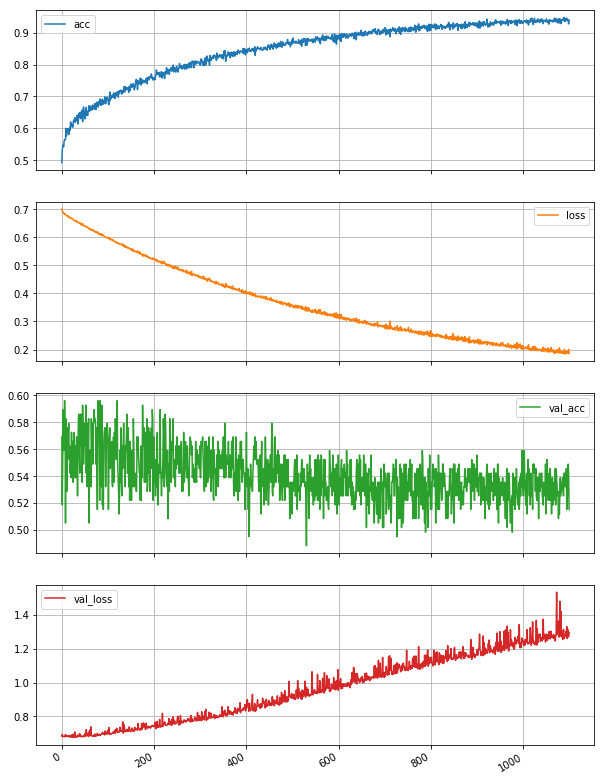

In [137]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

### Linear Regression on GSC dataset with concatenation

In [65]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03 #for regularization of closed form
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 20 # no of basis function
PHI = [] #Matrix for basis function
IsSynthetic = False

def GetTargetVector(filePath,k):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[k]))
    #print("Raw Training Generated..")
    return t
#append the csv file data in dataMatrix
def GenerateRawData(filePath, IsSynthetic,k):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row[0:k]:

                dataRow.append(float(column))
            dataMatrix.append(dataRow) 
    #delete those columns have variance 0 
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [450,452,456,457,962,964,968], axis=1)
    dataMatrix = np.transpose(dataMatrix)
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t
#Big sigma contains variance at the diagonal elements
#Big sigma contains variance at the diagonal elements
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    print(len(Data)) #rows 41#
    print(len(Data[0])) #columns 69k
    print(Data.shape)
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    print(len(DataT[0]))#column
    print(DataT.shape)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):#all columns of one feature
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))# variance of each feature vector as diagonal
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):#computing exponent function of gaussian basis function
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    # compute phi matrix
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI
#Computation of closed form solution to obtain weights
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W


#For obtaining validation erms , testing erms and training erms
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y
#get erms by subtracting actual value - obtained value and then squaring it 
#and then summing all of them.
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))




In [66]:
RawTarget = GetTargetVector('finalGSC.csv',1024)
RawData   = GenerateRawData('finalGSC.csv',IsSynthetic,1024)

TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)


ErmsArr = []
AccuracyArr = []
#In order to get different Mu specify value of M in K- Means
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 

TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 'U' mode is deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 'U' mode is deprecated


(114451,)
(1017, 114451)
(14306,)
(1017, 14306)
(14306,)
(1017, 14306)
1017
143063
(1017, 143063)
1017
(143063, 1017)


In [67]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt


W_Now        = np.zeros(20) #Randomly intiliaze weight at the beguning
print(W_Now)
La           = 2
learningRate = 0.01 #determines the step size for updating weights
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,1000):
    #process of updation of wts acc to stochastic gradient descent solution
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [68]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 0.0001\neta=0.003")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))



----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.003
E_rms Training   = 0.66896
E_rms Validation = 0.6738
E_rms Testing    = 0.67101


### Logistic Regression on GSC Dataset using Concatenation

In [72]:
RawTarget = GetTargetVector('finalGSC.csv',1024)
RawData   = GenerateRawData('finalGSC.csv',True,1024)

TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)





/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 'U' mode is deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 'U' mode is deprecated


(114451,)
(1024, 114451)
(14306,)
(1024, 14306)
(14306,)
(1024, 14306)


ValueError: shapes (1024,) and (114451,) not aligned: 1024 (dim 0) != 114451 (dim 0)

In [80]:
TrainingData = np.transpose(TrainingData)
wnew = np.zeros(1024)
b =0 
for i in range(114451):
    wnew = np.transpose(wnew)
    z = np.dot(wnew,TrainingData[i]) + b
    a = 1.0/(1.0+ math.exp(-z))
    #wnext = wnew - eta*(a-y)*xi
    wnext = wnew - np.dot(learningRate*(a-TrainingTarget[i]),TrainingData[i])
    wnew = wnext
    
    b = b - learningRate*(a - TrainingTarget[i])

In [81]:
test = []
def GetValTestLog(VAL_PHI,W):
    for i in range(114451):
        
        Y = np.dot(W,VAL_PHI[i])
        a = 1.0/(1.0+ math.exp(-Y))
        test.append(a) 
    return test
TR_TEST_OUT   = GetValTestLog(TrainingData,wnew) 

Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
L_Erms_Val.append(float(Erms_Val.split(',')[0]))
#print ("Accuracy Training   = " + str(np.around(min(L_Erms_TR),5)))
print("Accuracy Training = " + str(float(Erms_TR.split(',')[0])))


test = []
ValData = np.transpose(ValData)
def GetValTestLog(VAL_PHI,W):
    for i in range(14306):
        
        Y = np.dot(W,VAL_PHI[i])
        a = 1.0/(1.0+ math.exp(-Y))
        test.append(a) 
    return test
TR_TEST_OUT   = GetValTestLog(ValData,wnew) 

Erms_TR       = GetErms(TR_TEST_OUT,ValDataAct)
L_Erms_Val.append(float(Erms_Val.split(',')[0]))
#print ("Accuracy Validation = " + str(np.around(min(L_Erms_Val),5)))
print("Accuracy Validation = " + str(float(Erms_TR.split(',')[0])))

test1 = []
TestData = np.transpose(TestData)
def GetTestLog(VAL_PHI,W):
    for i in range(14303):
        
        Y = np.dot(W,VAL_PHI[i])
        a = 1.0/(1.0+ math.exp(-Y))
        test1.append(a) 
    return test1
TR_TEST_OUT   = GetTestLog(TestData,wnew) 

Erms_TR       = GetErms(TR_TEST_OUT,TestDataAct)
L_Erms_Test.append(float(Erms_Test.split(',')[0]))
#print ("accuracy Testing    = " + str(np.around(min(L_Erms_Test),5)))
print("Accuracy Testing = " + str(float(Erms_TR.split(',')[0])))

Accuracy Training = 58.114826432272324
Accuracy Validation = 58.143436320424996
Accuracy Testing = 57.659232328882055


### Linear Regression on GSC Dataset with subtraction

In [111]:
M = 10
RawTarget = GetTargetVector('finalGSCsub.csv',512)
RawData   = GenerateRawData('finalGSCsub.csv',IsSynthetic,512)

TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)


ErmsArr = []
AccuracyArr = []
#In order to get different Mu specify value of M in K- Means
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 

TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 'U' mode is deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 'U' mode is deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


(114451,)
(508, 114451)
(14306,)
(508, 14306)
(14306,)
(508, 14306)
508
143063
(508, 143063)
508
(143063, 508)


In [112]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt


W_Now        = np.zeros(10) #Randomly intiliaze weight at the beguning

La           = 2
learningRate = 0.01 #determines the step size for updating weights
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,400):
    #process of updation of wts acc to stochastic gradient descent solution
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [113]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 10 \nLambda  = 0.0001\neta=0.003")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))



----------Gradient Descent Solution--------------------
M = 10 
Lambda  = 0.0001
eta=0.003
E_rms Training   = 0.57937
E_rms Validation = 0.57979
E_rms Testing    = 0.58309


### Logistic Regression On GSC Dataset with subtraction

In [114]:
M = 10
RawTarget = GetTargetVector('finalGSCsub.csv',512)
RawData   = GenerateRawData('finalGSCsub.csv',True,512)

TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)





/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 'U' mode is deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 'U' mode is deprecated


(114451,)
(512, 114451)
(14306,)
(512, 14306)
(14306,)
(512, 14306)


In [123]:
TrainingData = np.transpose(TrainingData)
wnew = np.zeros(512)
b =0 
for i in range(114451):
    wnew = np.transpose(wnew)
    z = np.dot(wnew,TrainingData[i]) + b
    a = 1.0/(1.0+ math.exp(-z))
    #wnext = wnew - eta*(a-y)*xi
    wnext = wnew - np.dot(learningRate*(a-TrainingTarget[i]),TrainingData[i])
    wnew = wnext
    
    b = b - learningRate*(a - TrainingTarget[i])

In [124]:
test = []
def GetValTestLog(VAL_PHI,W):
    for i in range(114451):
        
        Y = np.dot(W,VAL_PHI[i])
        a = 1.0/(1.0+ math.exp(-Y))
        test.append(a) 
    return test
TR_TEST_OUT   = GetValTestLog(TrainingData,wnew) 

Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
L_Erms_Val.append(float(Erms_Val.split(',')[0]))
#print ("accuracy Training   = " + str(np.around(min(L_Erms_TR),5)))
print("Accuracy Training =" + str(float(Erms_TR.split(',')[0])))
test = []
ValData = np.transpose(ValData)
def GetValTestLog(VAL_PHI,W):
    for i in range(14306):
        
        Y = np.dot(W,VAL_PHI[i])
        a = 1.0/(1.0+ math.exp(-Y))
        test.append(a) 
    return test
TR_TEST_OUT   = GetValTestLog(ValData,wnew) 

Erms_TR       = GetErms(TR_TEST_OUT,ValDataAct)
#L_Erms_Val.append(float(Erms_Val.split(',')[0]))
#print ("accuracy Validation = " + str(np.around(min(L_Erms_Val),5)))
print("Accuracy Validation =" + str(float(Erms_TR.split(',')[0])))



test1 = []
TestData = np.transpose(TestData)
def GetTestLog(VAL_PHI,W):
    for i in range(14303):
        
        Y = np.dot(W,VAL_PHI[i])
        a = 1.0/(1.0+ math.exp(-Y))
        test1.append(a) 
    return test1
TR_TEST_OUT   = GetTestLog(TestData,wnew) 

Erms_TR       = GetErms(TR_TEST_OUT,TestDataAct)
#L_Erms_Test.append(float(Erms_Test.split(',')[0]))
#print ("accuracy Testing    = " + str(np.around(min(L_Erms_Test),5)))
print("Accuracy Testing =" + str(float(Erms_TR.split(',')[0])))



    
    #-----------------ValidationData Accuracy---------------------#
#VAL_TEST_OUT  = GetValTest(ValData,wnew) 
#Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
#print(Erms_Val)
#L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
#TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
#Erms_Test = GetErms(TEST_OUT,TestDataAct)
#L_Erms_Test.append(float(Erms_Test.split(',')[1]))

Accuracy Training =50.069462040523895
Accuracy Validation =50.07689081504264
Accuracy Testing =49.36726560861358


### Keras Implementation on GSC dataset using concatenation

In [82]:
import pandas as pd
def processData(dataset):
    
    # Why do we have to process?  We do not needvindexes, we only need values.
    #We are converting the dataset back to array 
    #for further processing them to binary form
    data   = dataset.iloc[:133063,0:1024]
    labels = dataset.iloc[:133063,1024]
    #to separately pass arrays to two different codes we converted the dataset to two different arrays
    #processedData  = encodeData(data)
    #processedLabel = encodeLabel(labels)
    print (data)
    print(labels)
    return data, labels

def testData(dataset): 
    data = dataset.iloc[133063:,0:1024] 
    labels = dataset.iloc[133063:,1024]
#to separately pass arrays to two different codes we converted the dataset to two different arrays
#processedData  = encodeData(data)
#processedLabel = encodeLabel(labels)
#print (data)
#print(labels)
    return data, labels

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import SGD
import numpy as np

input_size = 1024
drop_out = 0.2
first_dense_layer_nodes  = 512
second_dense_layer = 512
second_dense_layer_nodes = 1

def get_model():
    
    # Why do we need a model? A model is a core data  srtucture in keras and used to organize layers.
    # Why use Dense layer and then activation? We need to tell the system how the model is by specifying input and dense layer size,
    #after specifying we apply activation.
    # Why use sequential model with layers? sequential model is a linear way of stacking layers, 
    #where a layer connects just to the next layer. Here we have a fixed souce of input and output.
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    #relu always gives value such that if x<0 it will give 0 otherwise it will give the number itself
    #activation function are used to map input to output
    
    # Why dropout? WE used dropout to avoid overfitting of model
    #model.add(Dropout(drop_out))
    #model.add(Dense(second_dense_layer))
    #model.add(Activation('relu'))
        
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('sigmoid'))
    # Why Softmax?
    # softmax is an activation function used when we are doing classification 
    #and softmax will give probabilities of various classes involved
    model.summary()
    
    # Why use categorical_crossentropy? We use categorial cross entropy when the target is in categorical format
    # Here we are distribuiting the number in 4 categories, thus using categorical crossentropy
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # optimizer allows the internal learnable parameter (weights)to get adjusted.
    return model

In [83]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 525,313
Trainable params: 525,313
Non-trainable params: 0
_________________________________________________________________


In [84]:
validation_data_split = 0.2
num_epochs = 12
model_batch_size = 128
tb_batch_size = 20
early_patience = 100
#tensorboard is used for visualization
tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
#earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
#Early stopping happens when the quantity monitored stops increasing or decreasing
# Read Dataset
dataset = pd.read_csv('finalGSC.csv')
print(dataset)
# Process Dataset
processedData, processedLabel = processData(dataset)
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb]
                   )



        0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...    1.290  0.725  \
0       0    0    0    0    0    0    0    0    0    0  ...        0      0   
1       0    0    0    0    0    0    0    0    0    0  ...        0      0   
2       1    0    1    0    0    0    0    1    0    0  ...        0      0   
3       0    1    0    0    0    0    0    0    0    0  ...        0      0   
4       0    0    0    0    0    0    0    0    0    0  ...        0      0   
5       1    1    1    0    0    0    0    1    0    0  ...        0      0   
6       0    0    0    0    0    0    0    0    0    0  ...        0      0   
7       1    1    1    0    0    0    0    1    1    0  ...        0      0   
8       0    0    1    0    0    0    0    0    0    0  ...        0      0   
9       0    0    0    0    0    0    0    0    0    0  ...        0      0   
10      0    0    0    0    0    0    0    0    0    0  ...        0      0   
11      0    0    0    0    0    0    0    0    0   

Train on 106450 samples, validate on 26613 samples
Epoch 1/12
106450/106450 [==============================] - 13s 127us/step - loss: 0.4828 - acc: 0.7625 - val_loss: 0.3699 - val_acc: 0.8417
Epoch 2/12
106450/106450 [==============================] - 13s 120us/step - loss: 0.3014 - acc: 0.8704 - val_loss: 0.2551 - val_acc: 0.8984
Epoch 3/12
106450/106450 [==============================] - 12s 116us/step - loss: 0.2115 - acc: 0.9132 - val_loss: 0.2071 - val_acc: 0.9173
Epoch 4/12
106450/106450 [==============================] - 13s 123us/step - loss: 0.1556 - acc: 0.9383 - val_loss: 0.2242 - val_acc: 0.9038
Epoch 5/12
106450/106450 [==============================] - 13s 125us/step - loss: 0.1161 - acc: 0.9549 - val_loss: 0.1854 - val_acc: 0.9280
Epoch 6/12
106450/106450 [==============================] - 13s 120us/step - loss: 0.0897 - acc: 0.9660 - val_loss: 0.2457 - val_acc: 0.9152
Epoch 7/12
106450/106450 [==============================] - 13s 122us/step - loss: 0.0671 - acc: 0.9749

In [85]:
datatest = pd.read_csv('finalGSC.csv')
datatest1,datalabel = testData(datatest)
#np.set_printoptions(precision=4, suppress=True)
k,l = datatest1.shape
print(k)
eval_results = model.predict(datatest1)
#print("\nLoss, accuracy on test data: ")
#print("%0.4f %0.2f%%" % (eval_results[0], \
 #eval_results[1]*100))

for i in range(k):
    if(eval_results[i]>0.5):
        eval_results[i] = 1
    else:
        eval_results[i] = 0
        
eval_results

9999


array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [88]:
correct = 0
wrong = 0
for i in range(k):
    if (eval_results[i] == datalabel[133063+i]):
        correct = correct +1
    else:
        wrong = wrong + 1
        
print (correct/100)

93.35


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c3bd80438>,
      dtype=object)

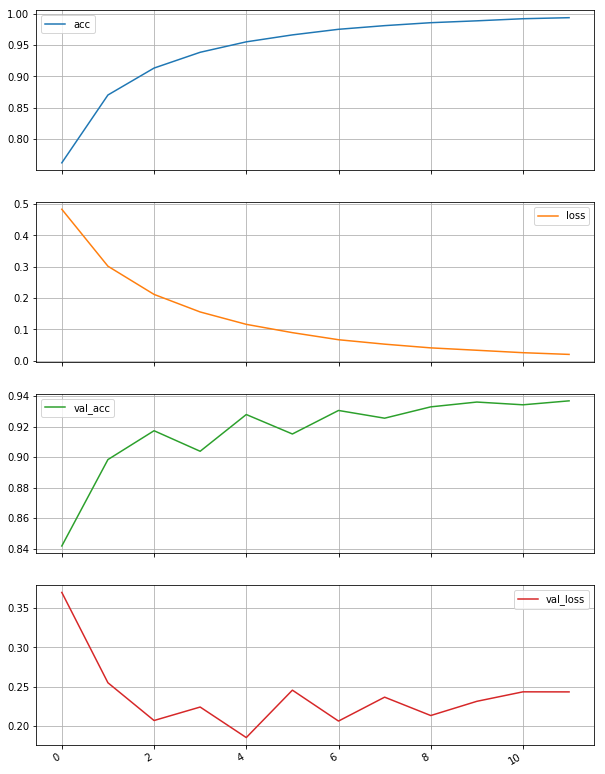

In [89]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

### Keras Implementation on GSC dataset using subtraction

In [101]:
import pandas as pd

In [102]:
def processData(dataset):
    
    # Why do we have to process?  We do not needvindexes, we only need values.
    #We are converting the dataset back to array 
    #for further processing them to binary form
    data   = dataset.iloc[:133063,0:512]
    labels = dataset.iloc[:133063,512]
    #to separately pass arrays to two different codes we converted the dataset to two different arrays
    #processedData  = encodeData(data)
    #processedLabel = encodeLabel(labels)
    print (data)
    print(labels)
    return data, labels

In [103]:
def testData(dataset): 
    data = dataset.iloc[133063:,0:512] 
    labels = dataset.iloc[133063:,512]
#to separately pass arrays to two different codes we converted the dataset to two different arrays
#processedData  = encodeData(data)
#processedLabel = encodeLabel(labels)
#print (data)
#print(labels)
    return data, labels

In [104]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import SGD
import numpy as np

input_size = 512
drop_out = 0.2
first_dense_layer_nodes  = 512
second_dense_layer = 512
second_dense_layer_nodes = 1

def get_model():
    
    # Why do we need a model? A model is a core data  srtucture in keras and used to organize layers.
    # Why use Dense layer and then activation? We need to tell the system how the model is by specifying input and dense layer size,
    #after specifying we apply activation.
    # Why use sequential model with layers? sequential model is a linear way of stacking layers, 
    #where a layer connects just to the next layer. Here we have a fixed souce of input and output.
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    #relu always gives value such that if x<0 it will give 0 otherwise it will give the number itself
    #activation function are used to map input to output
    
    # Why dropout? WE used dropout to avoid overfitting of model
    #model.add(Dropout(drop_out))
    #model.add(Dense(second_dense_layer))
    #model.add(Activation('relu'))
        
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('sigmoid'))
    # Why Softmax?
    # softmax is an activation function used when we are doing classification 
    #and softmax will give probabilities of various classes involved
    model.summary()
    
    # Why use categorical_crossentropy? We use categorial cross entropy when the target is in categorical format
    # Here we are distribuiting the number in 4 categories, thus using categorical crossentropy
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # optimizer allows the internal learnable parameter (weights)to get adjusted.
    return model

In [106]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total params: 263,169
Trainable params: 263,169
Non-trainable params: 0
_________________________________________________________________


In [107]:
validation_data_split = 0.2
num_epochs = 50
model_batch_size = 128
tb_batch_size = 20
early_patience = 100
#tensorboard is used for visualization
tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
#earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
#Early stopping happens when the quantity monitored stops increasing or decreasing
# Read Dataset
dataset = pd.read_csv('finalGSCsub.csv')
print(dataset)
# Process Dataset
processedData, processedLabel = processData(dataset)
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb]
                   )




        0  1  1.1  0.1  0.2  0.3  0.4  0.5  0.6  0.7  ...    0.360  0.361  \
0       0  0    0    0    0    0    0    0    0    0  ...        0      0   
1       0  1    1    0    0    0    0    0    0    0  ...        1      0   
2       0  0    0    0    0    0    0    0    0    0  ...        0      0   
3       0  0    0    0    0    0    0    0    0    0  ...        0      0   
4       0  0    0    0    0    0    0    0    0    0  ...        0      0   
5       0  0    0    0    0    0    0    0    0    0  ...        0      0   
6       1  0    1    0    1    0    1    0    1    0  ...        0      0   
7       0  0    0    0    0    0    0    0    0    0  ...        0      0   
8       0  0    0    0    0    0    0    0    0    0  ...        0      0   
9       0  0    0    0    0    0    0    0    0    0  ...        0      0   
10      0  0    0    0    0    0    0    0    0    0  ...        0      0   
11      0  1    0    0    1    0    0    0    0    0  ...        0      0   

Train on 106450 samples, validate on 26613 samples
Epoch 1/50
106450/106450 [==============================] - 6s 60us/step - loss: 0.4753 - acc: 0.7710 - val_loss: 0.4491 - val_acc: 0.7899
Epoch 2/50
106450/106450 [==============================] - 6s 54us/step - loss: 0.3706 - acc: 0.8349 - val_loss: 0.3744 - val_acc: 0.8308
Epoch 3/50
106450/106450 [==============================] - 6s 57us/step - loss: 0.3130 - acc: 0.8654 - val_loss: 0.4041 - val_acc: 0.8205
Epoch 4/50
106450/106450 [==============================] - 5s 52us/step - loss: 0.2654 - acc: 0.8896 - val_loss: 0.3614 - val_acc: 0.8475
Epoch 5/50
106450/106450 [==============================] - 6s 54us/step - loss: 0.2230 - acc: 0.9097 - val_loss: 0.3718 - val_acc: 0.8436
Epoch 6/50
106450/106450 [==============================] - 6s 54us/step - loss: 0.1852 - acc: 0.9269 - val_loss: 0.3634 - val_acc: 0.8536
Epoch 7/50
106450/106450 [==============================] - 6s 55us/step - loss: 0.1493 - acc: 0.9432 - val_loss: 0

In [108]:
datatest = pd.read_csv('finalGSCsub.csv')
datatest1,datalabel = testData(datatest)
#np.set_printoptions(precision=4, suppress=True)
k,l = datatest1.shape
print(k)
eval_results = model.predict(datatest1)
#print("\nLoss, accuracy on test data: ")
#print("%0.4f %0.2f%%" % (eval_results[0], \
 #eval_results[1]*100))

for i in range(9999):
    if(eval_results[i]>0.5):
        eval_results[i] = 1
    else:
        eval_results[i] = 0
        
eval_results

9999


array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [109]:
correct = 0
wrong = 0
for i in range(k):
    if (eval_results[i] == datalabel[133063+i]):
        correct = correct +1
    else:
        wrong = wrong + 1
        
print (correct/100)

85.69


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c37302908>,
      dtype=object)

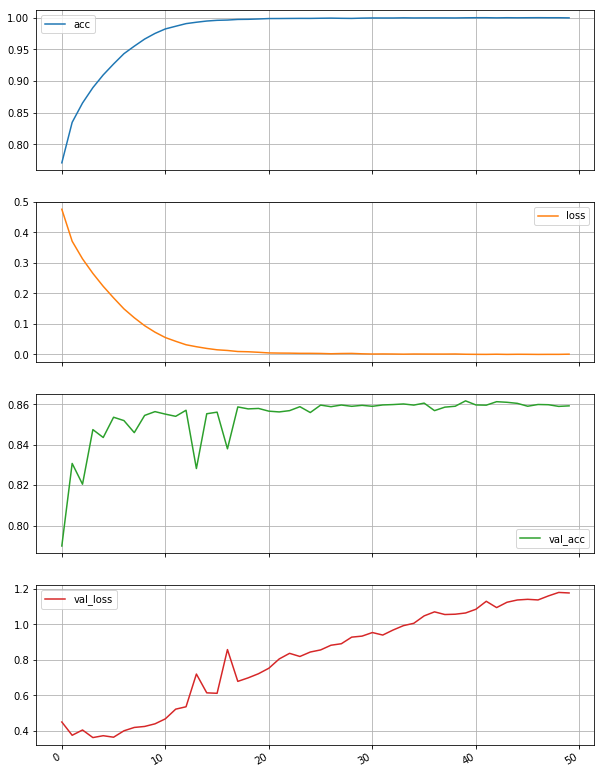

In [110]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

### Code Creation for human observed dataset

In [116]:

'''import csv
import pandas
import numpy as np
data1 = []
with open ('same_pairs.csv') as csv_file:
    readCSV = csv.reader(csv_file, delimiter=',')
    for row in readCSV:
        data1.append(row)
df1 = pandas.DataFrame(data = data1)        
data2 = []        
with open ('diffn_pairs.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        data2.append(row)
df2 = pandas.DataFrame(data = data2)    
data3 = []        
with open ('HumanObserved-Features-Data.csv') as csvfile2:
    readCSV = csv.reader(csvfile2, delimiter=',')
    for row in readCSV:
        data3.append(row)
df3 = pandas.DataFrame(data = data3)    
'''


"import csv\nimport pandas\nimport numpy as np\ndata1 = []\nwith open ('same_pairs.csv') as csv_file:\n    readCSV = csv.reader(csv_file, delimiter=',')\n    for row in readCSV:\n        data1.append(row)\ndf1 = pandas.DataFrame(data = data1)        \ndata2 = []        \nwith open ('diffn_pairs.csv') as csvfile:\n    readCSV = csv.reader(csvfile, delimiter=',')\n    for row in readCSV:\n        data2.append(row)\ndf2 = pandas.DataFrame(data = data2)    \ndata3 = []        \nwith open ('HumanObserved-Features-Data.csv') as csvfile2:\n    readCSV = csv.reader(csvfile2, delimiter=',')\n    for row in readCSV:\n        data3.append(row)\ndf3 = pandas.DataFrame(data = data3)    \n"

In [125]:
'''data4 = []
data5 =[]
n,l = df1.shape
k,l = df3.shape

for i in range(n):
    for j in range(k):
        if(i==0):
            break
        if(data1[i][0] == data3[j][1]):
            break;
    data4.append(data3[j][2:11])
for i in range(n):
    for j in range(k):
        if i ==0 :
            break
        if(data1[i][1] == data3[j][1]):
            break;
    data5.append(data3[j][2:11])'''

'data4 = []\ndata5 =[]\nn,l = df1.shape\nk,l = df3.shape\n\nfor i in range(n):\n    for j in range(k):\n        if(i==0):\n            break\n        if(data1[i][0] == data3[j][1]):\n            break;\n    data4.append(data3[j][2:11])\nfor i in range(n):\n    for j in range(k):\n        if i ==0 :\n            break\n        if(data1[i][1] == data3[j][1]):\n            break;\n    data5.append(data3[j][2:11])'

In [126]:
'''data6 = []
data7 =[]
n,l = df2.shape
k,l = df3.shape

for i in range(n):
    for j in range(k):
        if(i==0):
            break
        if(data2[i][0] == data3[j][1]):
            break;
    data6.append(data3[j][2:11])
for i in range(n):
    for j in range(k):
        if i ==0 :
            break
        if(data2[i][1] == data3[j][1]):
            break;
    data7.append(data3[j][2:11])'''




'data6 = []\ndata7 =[]\nn,l = df2.shape\nk,l = df3.shape\n\nfor i in range(n):\n    for j in range(k):\n        if(i==0):\n            break\n        if(data2[i][0] == data3[j][1]):\n            break;\n    data6.append(data3[j][2:11])\nfor i in range(n):\n    for j in range(k):\n        if i ==0 :\n            break\n        if(data2[i][1] == data3[j][1]):\n            break;\n    data7.append(data3[j][2:11])'

In [127]:
'''df4 = pandas.DataFrame(data = data4)
m,t = df4.shape
df6 = pandas.DataFrame(data = data6)
k,l = df6.shape
datafinal = [[0 for i in range(t+10)]for j in range(m-1)]
datafinal2 = [[0 for i in range(t+10)]for j in range(k-1)]
for i in range(m-1):
    for j in range(t):
        datafinal[i][j] = data4[i+1][j]
        datafinal[i][j+9] = data5[i+1][j]
        datafinal[i][j+10] = data1[i+1][2]
for i in range(k-1):
    for j in range(l):
        datafinal2[i][j] = data6[i+1][j]
        datafinal2[i][j+9] = data7[i+1][j]
        datafinal2[i][j+10] = data2[i+1][2]   
import numpy as np

datafinal2 = np.asarray(datafinal2)
#f4 = pandas.DataFrame(data = datafinal)
#a, b =f4.shape
#a

np.random.shuffle(datafinal2)

z = 2*m
print (z)
dff = [[0 for i in range(t+10)]for j in range(z-1)]
for i in range(m-1):
    for j in range(t+10):
        dff[i][j] = datafinal[i][j]

for i in range(m-1):
    for j in range(t+10):
        dff[m+i][j] = datafinal2[i][j]
        
        
dff = np.asarray(dff)
np.random.shuffle(dff)
#k,l =dff.shape
#k
dffinal2 = pandas.DataFrame(data= dff)
dffinal2.to_csv('final1600.csv',header =0 , index =0)'''

"df4 = pandas.DataFrame(data = data4)\nm,t = df4.shape\ndf6 = pandas.DataFrame(data = data6)\nk,l = df6.shape\ndatafinal = [[0 for i in range(t+10)]for j in range(m-1)]\ndatafinal2 = [[0 for i in range(t+10)]for j in range(k-1)]\nfor i in range(m-1):\n    for j in range(t):\n        datafinal[i][j] = data4[i+1][j]\n        datafinal[i][j+9] = data5[i+1][j]\n        datafinal[i][j+10] = data1[i+1][2]\nfor i in range(k-1):\n    for j in range(l):\n        datafinal2[i][j] = data6[i+1][j]\n        datafinal2[i][j+9] = data7[i+1][j]\n        datafinal2[i][j+10] = data2[i+1][2]   \nimport numpy as np\n\ndatafinal2 = np.asarray(datafinal2)\n#f4 = pandas.DataFrame(data = datafinal)\n#a, b =f4.shape\n#a\n\nnp.random.shuffle(datafinal2)\n\nz = 2*m\nprint (z)\ndff = [[0 for i in range(t+10)]for j in range(z-1)]\nfor i in range(m-1):\n    for j in range(t+10):\n        dff[i][j] = datafinal[i][j]\n\nfor i in range(m-1):\n    for j in range(t+10):\n        dff[m+i][j] = datafinal2[i][j]\n        \

### Code for creation of GSC dataset

In [ ]:
'''import csv
import pandas
import numpy as np
data1 = []
with open ('same_pairsGSC.csv') as csv_file:
    readCSV = csv.reader(csv_file, delimiter=',')
    for row in readCSV:
        data1.append(row)
df1 = pandas.DataFrame(data = data1)  
k,l = df1.shape
print(k,l)
data2 = []        
with open ('diffn_pairsGSC.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        data2.append(row)
df2 = pandas.DataFrame(data = data2)
m,n =df2.shape
print(m,n)
data3 = []        
with open ('GSC-Features.csv') as csvfile2:
    readCSV = csv.reader(csvfile2, delimiter=',')
    for row in readCSV:
        data3.append(row)
df3 = pandas.DataFrame(data = data3)    
df3

import numpy as np

df = np.asarray(df2)
#f4 = pandas.DataFrame(data = datafinal)
#a, b =f4.shape
#a

np.random.shuffle(df)
s,t = df.shape
print(s,t)
print(df)
#df = pandas.DataFrame(data = df)
#datafinal =[[ 0 for j in range(l)]for i in range(k)]
#for i in range(k):
#    for j in range(l):
#        datafinal[i][j] = df[i][j]
 
datafinal = df[:71532,:]

dfk = pandas.DataFrame(data = datafinal)
dfk.shape

data4 = []
data5 =[]
n,l = df1.shape
k,l = df3.shape

for i in range(n):
    for j in range(k):
        if(i==0):
            break
        if(data1[i][0] == data3[j][0]):
            break;
    data4.append(data3[j][1:513])
for i in range(n):
    for j in range(k):
        if i ==0 :
            break
        if(data1[i][1] == data3[j][0]):
            break;
    data5.append(data3[j][1:513])
    
data4

df4 = pandas.DataFrame(data = data4)
m,t = df4.shape
df6 = pandas.DataFrame(data = data6)
k,l = df6.shape
print(k,l)
dataf2 = [[0 for i in range(t+513)]for j in range(m-1)]
datafinal2 = [[0 for i in range(l+513)]for j in range(k-1)]
#datafinal2.shape
for i in range(m-1):
    for j in range(t):
        dataf2[i][j] = data4[i+1][j]
        dataf2[i][j+512] = data5[i+1][j]
    dataf2[i][1024] = data1[i+1][2]
for i in range(k-1):
    for j in range(l):
        datafinal2[i][j] = data6[i+1][j]
        datafinal2[i][j+512] = data7[i+1][j]
    datafinal2[i][1024] = data2[i+1][2]        
    
    
import numpy as np

datafinal2 = np.asarray(datafinal2)
#f4 = pandas.DataFrame(data = datafinal)
#a, b =f4.shape
#a

#np.random.shuffle(datafinal2)

z = m + k
print (z)
dff = [[0 for i in range(1025)]for j in range(z)]
for i in range(m-1):
    for j in range(1025):
        dff[i][j] = dataf2[i][j]

for i in range(k-1):
    for j in range(1025):
        dff[m-1+i][j] = datafinal2[i][j]
        
        
dff = np.asarray(dff)
np.random.shuffle(dff)
#k,l =dff.shape
#k
dffinal2 = pandas.DataFrame(data= dff)
dffinal2.to_csv('finalGSC.csv',header =0 , index =0)


'''
